# Data Preprocessing pipeline & analysis
In this notebook, the data is preprocessed for our Conditional Deep Generative Modelling

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

WORKING_DIR = r'C:\Thesis\data'
DATA_FILE_PATH_2021 = os.path.join(WORKING_DIR,'raw','READING_2021.csv')
MASTER_FILE_PATH_2021 = os.path.join(WORKING_DIR, 'raw', '1_50-aanlevering-dmk-e-kwartierwaarden.csv')
DATA_FILE_PATH_2016 = os.path.join(WORKING_DIR,'raw', 'READING_2016_FIXED.CSV')
MASTER_FILE_PATH_2016 = os.path.join(WORKING_DIR, 'raw', 'master-table-meters.csv')

### 0.1 Load & prepare measurements 2021
Load the data and master table of 2021.
- Drop duplicates based on ID, Datetime, offtake and injection values
- Add extra Consumption column, round of to 4 digits

In [2]:
DATA_COLUMN_NAMES = ['ID', 'Datetime', 'Offtake', 'Injection']
MASTER_COLUMN_NAMES = ['ID', 'Yearly Offtake', 'Yearly Injection']
DATA_USECOLS = [0, 2, 3, 4]
MASTER_USECOLS = [0, 3, 4]
DATE_FORMAT = "%Y-%m-%dT%H:%M:%S.%fZ"

### DATA TABLE
with open(DATA_FILE_PATH_2021) as file:   
    data2021 = pd.read_csv(file, 
                   sep=',',
                   header = 0,
                   usecols=DATA_USECOLS,
                   names=DATA_COLUMN_NAMES,
                   decimal='.')

#Convert Datetime column to datetime object    
data2021['Datetime'] = pd.to_datetime(data2021['Datetime'], format=DATE_FORMAT)
print("NaN values in Offtake column:", data2021['Offtake'].isna().sum())
print("NaN values in Injection column:", data2021['Injection'].isna().sum())
# drop duplicates readings for the same installation, time and measurement type (injection or offtake), 
data2021.drop_duplicates(subset = ['ID', 'Datetime', 'Offtake','Injection'], keep = 'first', inplace=True)

data2021 = data2021.groupby(['ID', 'Datetime']).agg({'Offtake': 'sum', 'Injection': 'sum'})

#Create extra column with the total consumption every 15 minutes
data2021['Consumption'] = np.round(np.nansum([data2021['Offtake'], -data2021['Injection']], axis=0), 4)

### MASTER TABLE
with open(MASTER_FILE_PATH_2021) as file:
    data_master2021 = pd.read_csv(file, 
                            sep=';',
                            header=0,
                            usecols=MASTER_USECOLS,
                            names=MASTER_COLUMN_NAMES,
                            decimal='.')

data_master2021 = data_master2021.groupby('ID').agg({'Yearly Offtake': 'sum', 'Yearly Injection': 'sum'})

data2021.head()

NaN values in Offtake column: 0
NaN values in Injection column: 0


Offtake  Injection  Consumption
ID Datetime                                            
1  2021-01-01 00:00:00    0.076        0.0        0.076
   2021-01-01 00:15:00    0.048        0.0        0.048
   2021-01-01 00:30:00    0.038        0.0        0.038
   2021-01-01 00:45:00    0.317        0.0        0.317
   2021-01-01 01:00:00    0.570        0.0        0.570

### 0.2 Load & prepare measurements 2016
Load the data and master table of 2016.
- Drop duplicates based on ID, Datetime, offtake and injection values
- Add extra Consumption column, round of to 4 digits
- Use the master table, to add the households with the same locationID together to create one instance.

In [3]:
DATA_COLUMN_NAMES = ['ID', 'Offtake/Injection', 'Datetime', 'Value']
MASTER_COLUMN_NAMES = ['ID', 'Yearly Offtake', 'Yearly Injection', 'LocationID']
DATA_USECOLS = [2, 3, 4, 6]
MASTER_USECOLS = [0, 4, 5, 7]

### DATA TABLE
with open(DATA_FILE_PATH_2016) as file:
    data2016 = pd.read_csv(file, 
                   sep=';',
                   header = 0,
                   usecols=DATA_USECOLS,
                   names=DATA_COLUMN_NAMES,
                   converters={'Offtake/Injection': lambda x: 'Offtake' if x == 'Afname' else 'Injection'}, #translate
                   decimal='.')
    
### MASTER TABLE
with open(MASTER_FILE_PATH_2016) as file:
    data_master2016 = pd.read_csv(file, 
                            sep=';',
                            header=0,
                            usecols=MASTER_USECOLS,
                            index_col=0,
                            names=MASTER_COLUMN_NAMES,
                            decimal='.')
    
print('Amount of unique households:',len(np.unique(data_master2016['LocationID'])))
ids = np.unique(data_master2016['LocationID'])
data2016 = data2016.join(data_master2016['LocationID'], on='ID').drop(columns=['ID'])
data2016['Datetime'] = pd.to_datetime(data2016['Datetime'])

#Create new columns
data2016['Offtake'] = data2016['Value'].where(data2016['Offtake/Injection'] == 'Offtake', 0.0)
data2016['Injection'] = data2016['Value'].where(data2016['Offtake/Injection'] == 'Injection', 0.0)
data2016.drop(columns=['Offtake/Injection', 'Value'],inplace=True)

data2016 = data2016.rename(columns={'LocationID':'ID'})
data2016 = data2016.groupby(['ID','Datetime']).agg({'Offtake': 'sum', 'Injection': 'sum'})

#create new table with correct days
data_range = pd.date_range(start='1/1/2016', end='12/31/2016 23:45:00', freq='15min')
idx = pd.MultiIndex.from_product([ids, data_range], names=['ID', 'Datetime'])
new_df = pd.DataFrame().reindex(idx,fill_value=0)

data2016 = pd.merge(new_df, data2016,left_index=True, right_index=True, how='left')


#Create extra column with the total consumption every 15 minutes
data2016['Consumption'] = np.round(np.sum([data2016['Offtake'], -data2016['Injection']], axis=0), 4)

print("NaN values in Offtake column:", data2016['Offtake'].isna().sum())
print("NaN values in Injection column:", data2016['Injection'].isna().sum())
print("NaN values in Consumption column:", data2016['Consumption'].isna().sum())

data_master2016 = data_master2016.groupby('LocationID').agg({'Yearly Offtake': 'sum', 'Yearly Injection': 'sum'})
data_master2016 = data_master2016.rename_axis(['ID'])

data2016.head()

Amount of unique households: 100
NaN values in Offtake column: 7252
NaN values in Injection column: 7252
NaN values in Consumption column: 7252


Offtake  Injection  Consumption
ID     Datetime                                            
#NAAM? 2016-01-01 00:00:00     0.17        0.0         0.17
       2016-01-01 00:15:00     0.31        0.0         0.31
       2016-01-01 00:30:00     0.14        0.0         0.14
       2016-01-01 00:45:00     0.04        0.0         0.04
       2016-01-01 01:00:00     0.07        0.0         0.07

### 1.0 Analysis and filtering

C:\Users\jankr\AppData\Local\Temp\ipykernel_19284\2308347764.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


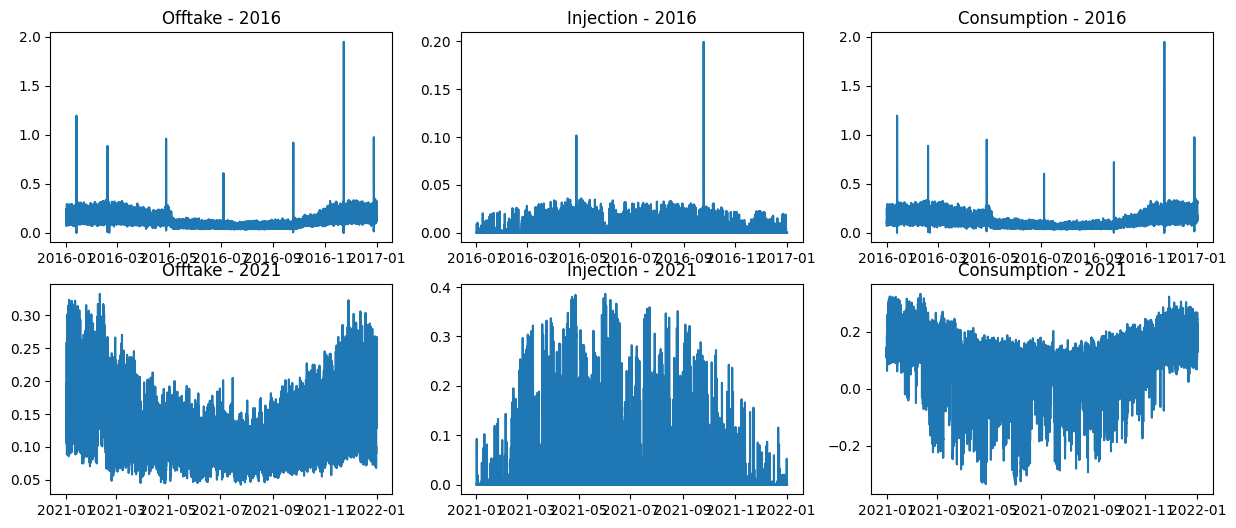

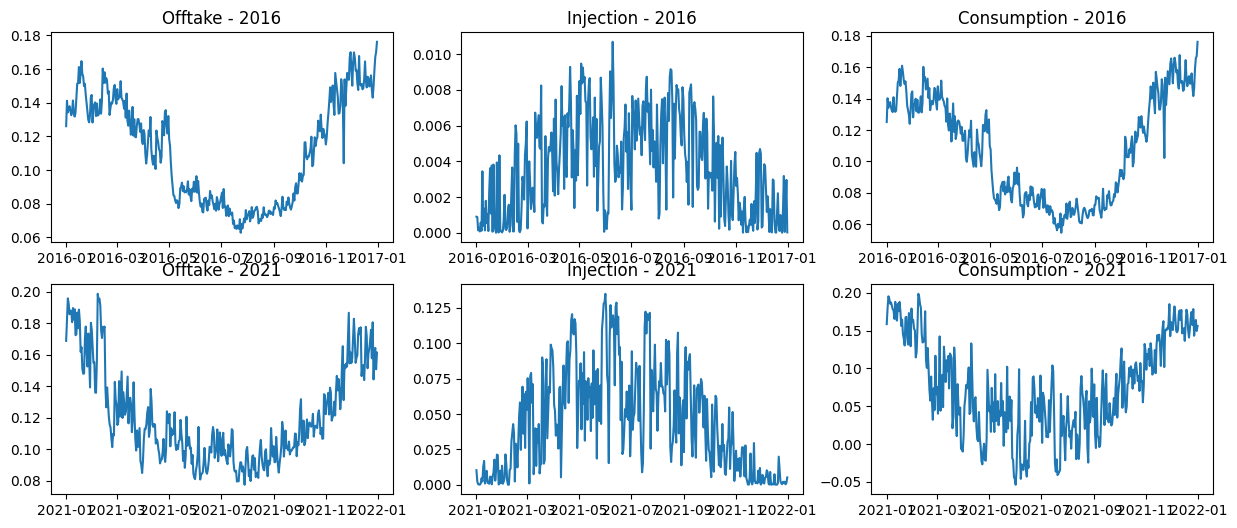

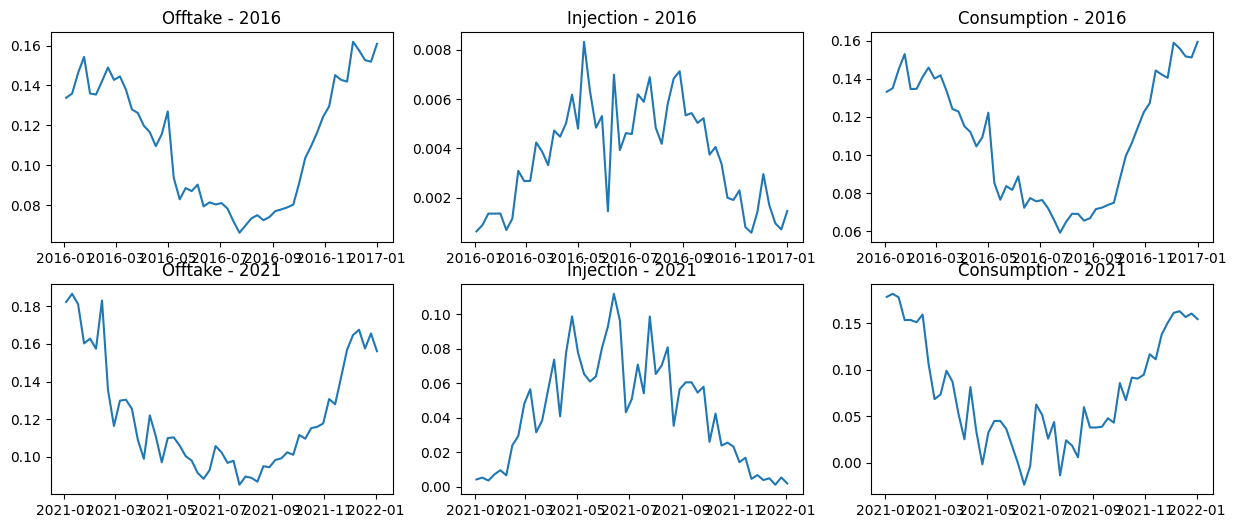

In [4]:
temp2016 = data2016.copy()
temp2021 = data2021.copy()

#Groupby datetime & calculate the mean

temp2021 = temp2021.groupby(['Datetime']).agg({'Offtake': 'mean', 'Injection': 'mean','Consumption': 'mean'})
temp2016 = data2016.groupby(['Datetime']).agg({'Offtake': 'mean', 'Injection': 'mean','Consumption': 'mean'})

def plot_data(data, resample_freq):
    fig, axs = plt.subplots(len(data), 3, figsize=(15, 6))
    for i,d in enumerate(['2016','2021']):
        data_resampled = data[i].resample(resample_freq).mean()
        for index, col in enumerate(['Offtake', 'Injection','Consumption']):
            axs[i,index].plot(data_resampled[col])
            axs[i,index].set_title(f'{col} - {d}')
    fig.show()


plot_data([temp2016, temp2021],'15MIN')
plot_data([temp2016, temp2021],'1D')
plot_data([temp2016, temp2021],'1W')

TAKE AWAYS:
- The data of 2016 shows some peaks, which will have to be filtered out. We'll tackle this later on by removing the days with such high peaks
- Both datasets also contain some negative values, which shouldn't be negative. --> convert them to 0
- There is a clear correlation with the season/months of the year, which show lower offtake and higher injection

### 1.1 Remove negative values
Clip the negative values in the offtake and injection columns to 0

In [5]:
data2021[['Offtake','Injection']] = data2021[['Offtake','Injection']].clip(lower=0)
data2016[['Offtake','Injection']] = data2016[['Offtake','Injection']].clip(lower=0)

#recalculate consumption
data2021['Consumption'] = np.round(np.nansum([data2021['Offtake'], -data2021['Injection']], axis=0), 4)
data2016['Consumption'] = np.round(np.nansum([data2016['Offtake'], -data2016['Injection']], axis=0), 4)

### 1.2 Remove households with large yearly offtake / injection

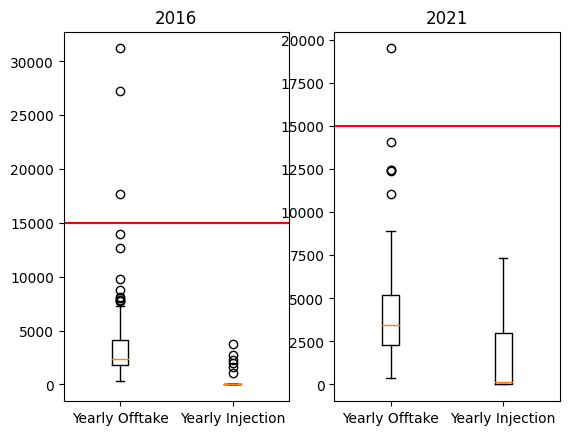

In [6]:
fig, axs = plt.subplots(1,2)
axs[0].boxplot(data_master2016[['Yearly Offtake','Yearly Injection']],labels=['Yearly Offtake','Yearly Injection'])
axs[1].boxplot(data_master2021[['Yearly Offtake','Yearly Injection']],labels=['Yearly Offtake','Yearly Injection'])
axs[0].set_title("2016")
axs[0].axhline(y = 15000, color = 'r')
axs[1].set_title("2021")
axs[1].axhline(y = 15000, color = 'r');

Based on the boxplots, we remove the values with an offtake value higher then 15000

In [7]:
THRESHOLD = 15000
ids = data_master2021[data_master2021['Yearly Offtake'] > THRESHOLD]
data2021.drop(labels=ids.index.values,inplace=True)
data_master2021.drop(labels=ids.index.values,inplace=True)

ids = data_master2016[data_master2016['Yearly Offtake'] > THRESHOLD]
data2016.drop(labels=ids.index.values,inplace=True)
data_master2016.drop(labels=ids.index.values,inplace=True)

### 1.3 Handle zero values
**Still not sure what to do with this. Both datasets show very different kind of measeruments it seems**

- It seems that many zero values from the offtake get resolved by calculating the consumption. However, there still remains id's with an immense amount of zero values, let's filter these ones out
- This seems to be a problem mainly in the 2016 dataset

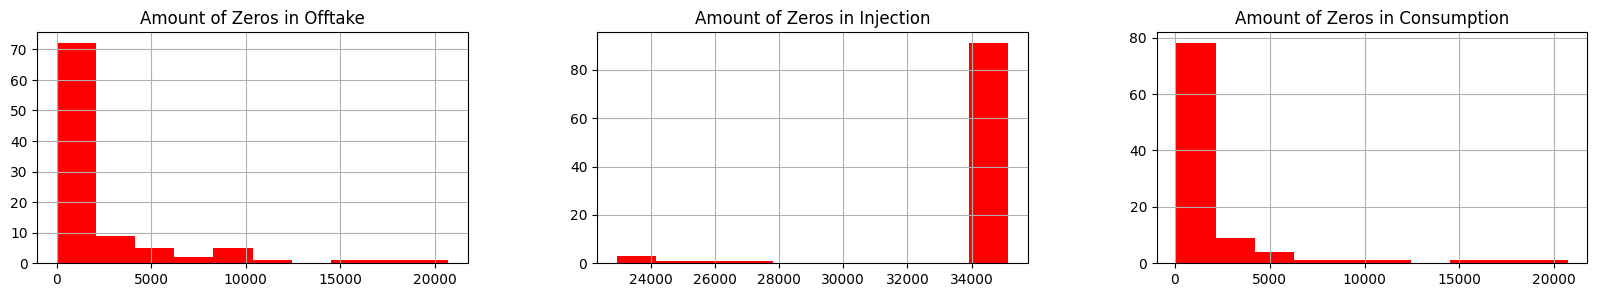

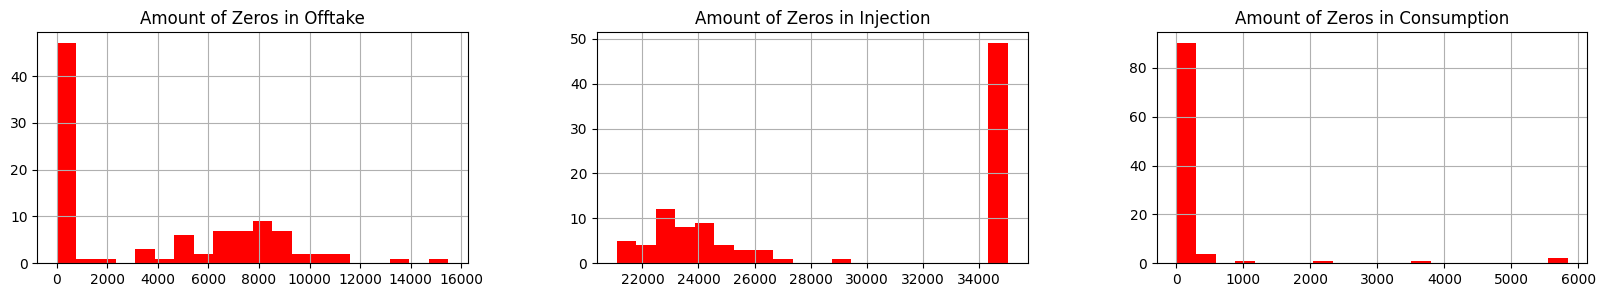

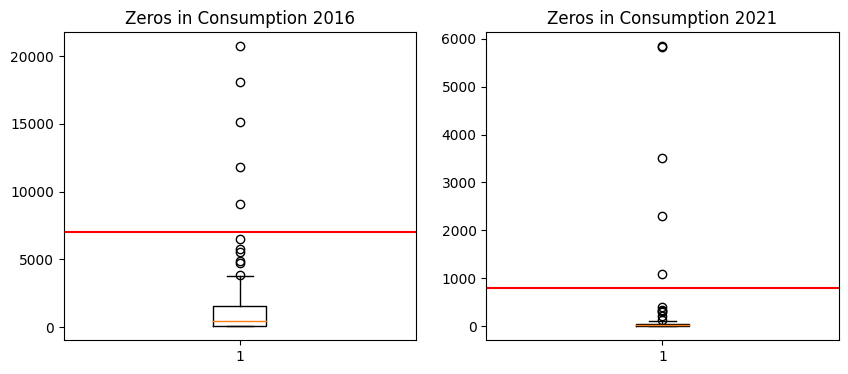

In [8]:
zeros2016 = pd.DataFrame({'Amount of Zeros in Offtake':(data2016['Offtake'] == 0).groupby('ID').sum(),
                          'Amount of Zeros in Injection':(data2016['Injection'] == 0).groupby('ID').sum(),
                          'Amount of Zeros in Consumption':(data2016['Consumption'] == 0).groupby('ID').sum()})
zeros2021 = pd.DataFrame({'Amount of Zeros in Offtake':(data2021['Offtake'] == 0).groupby('ID').sum(),
                          'Amount of Zeros in Injection':(data2021['Injection'] == 0).groupby('ID').sum(),
                          'Amount of Zeros in Consumption':(data2021['Consumption'] == 0).groupby('ID').sum()})

zeros2016.hist(bins=10,figsize=(20,3),layout=(1,3),color='r',alpha=1)
zeros2021.hist(bins=20,figsize=(20,3),layout=(1,3),color='r',alpha=1)

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].set_title('Zeros in Consumption 2016')
axs[0].boxplot(zeros2016['Amount of Zeros in Consumption']);
axs[0].axhline(y = 7000, color = 'r');

axs[1].set_title('Zeros in Consumption 2021')
axs[1].boxplot(zeros2021['Amount of Zeros in Consumption']);
axs[1].axhline(y = 800, color = 'r');

In [9]:
# I just remove the numbers above choosen thresholdd.

upper_whisper = 7000
ids = zeros2016[zeros2016['Amount of Zeros in Consumption'] > upper_whisper]
data2016.drop(labels=ids.index.values,inplace=True)
data_master2016.drop(labels=ids.index.values,inplace=True)
print('remove',len(ids),'households from 2016')

upper_whisper = 800
ids = zeros2021[zeros2021['Amount of Zeros in Consumption'] > upper_whisper]
data2021.drop(labels=ids.index.values,inplace=True)
data_master2021.drop(labels=ids.index.values,inplace=True)
print('remove',len(ids),'households from 2021')

remove 5 households from 2016
remove 5 households from 2021


### 1.4 Save

In [10]:
data2016.to_pickle(os.path.join(WORKING_DIR,'data2016_filtered.pkl'))
data_master2016.to_pickle(os.path.join(WORKING_DIR,'data2016_master_filtered.pkl'))

data2021.to_pickle(os.path.join(WORKING_DIR,'data2021_filtered.pkl'))
data_master2021.to_pickle(os.path.join(WORKING_DIR,'data2021_master_filtered.pkl'))

## 2. Convert to Days

In [11]:
#2016
data2016 = pd.read_pickle(os.path.join(WORKING_DIR,'data2016_filtered.pkl'))
data_master2016  = pd.read_pickle(os.path.join(WORKING_DIR,'data2016_master_filtered.pkl'))

data2016 = data2016.reset_index()
data2016['date'] = data2016['Datetime'].dt.date
data2016['time'] = data2016['Datetime'].dt.time

measures_per_day2016 = data2016.pivot_table(index=['ID','date'],columns=['time'],values=['Consumption'])
#drop days where a possible nan might be introduced
measures_per_day2016.dropna(how='any', inplace=True)
measures_per_day2016.columns = measures_per_day2016.columns.droplevel()
# measures_per_day2016.columns = np.arange(0,96,1)
measures_per_day2016.to_pickle( os.path.join(WORKING_DIR,f'data2016_per_day.pkl'))

#2021
data2021 = pd.read_pickle(os.path.join(WORKING_DIR,'data2021_filtered.pkl'))
data_master2021  = pd.read_pickle(os.path.join(WORKING_DIR,'data2021_master_filtered.pkl'))

data2021 = data2021.reset_index()
data2021['date'] = data2021['Datetime'].dt.date
data2021['time'] = data2021['Datetime'].dt.time

measures_per_day2021 = data2021.pivot_table(index=['ID','date'],columns=['time'],values=['Consumption'])
measures_per_day2021.dropna(how='any', inplace=True)
measures_per_day2021.columns = measures_per_day2021.columns.droplevel()
# measures_per_day2021.columns = np.arange(0,96,1)
measures_per_day2021.to_pickle( os.path.join(WORKING_DIR,f'data2021_per_day.pkl'))

### 2.1 Analyze the days

Make at first glance a boxplot on every timestamp and observe possible outliers

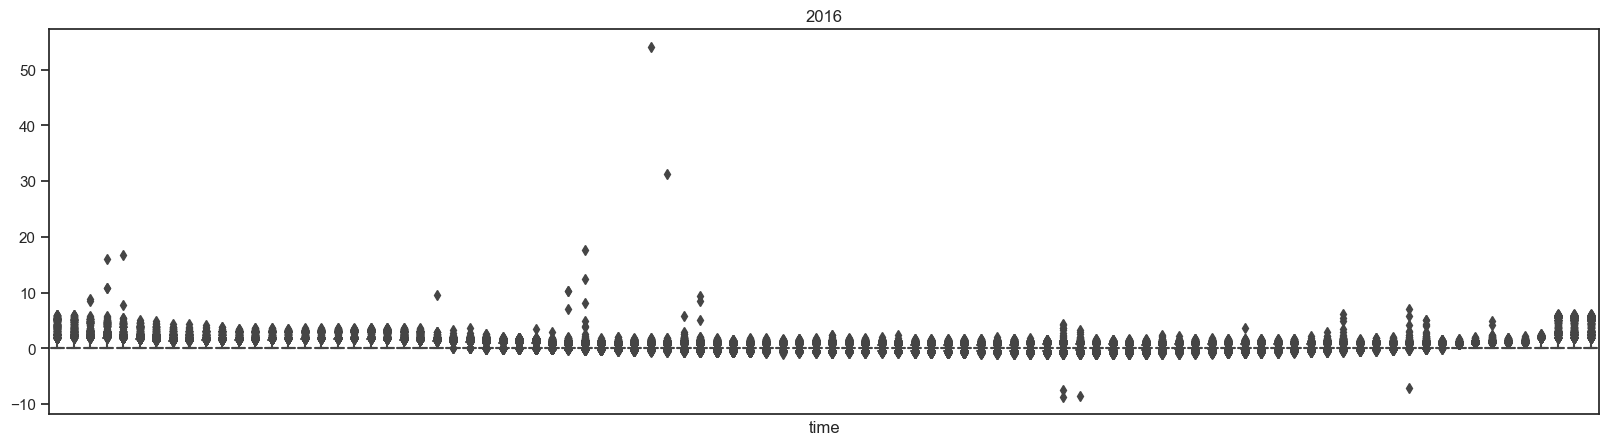

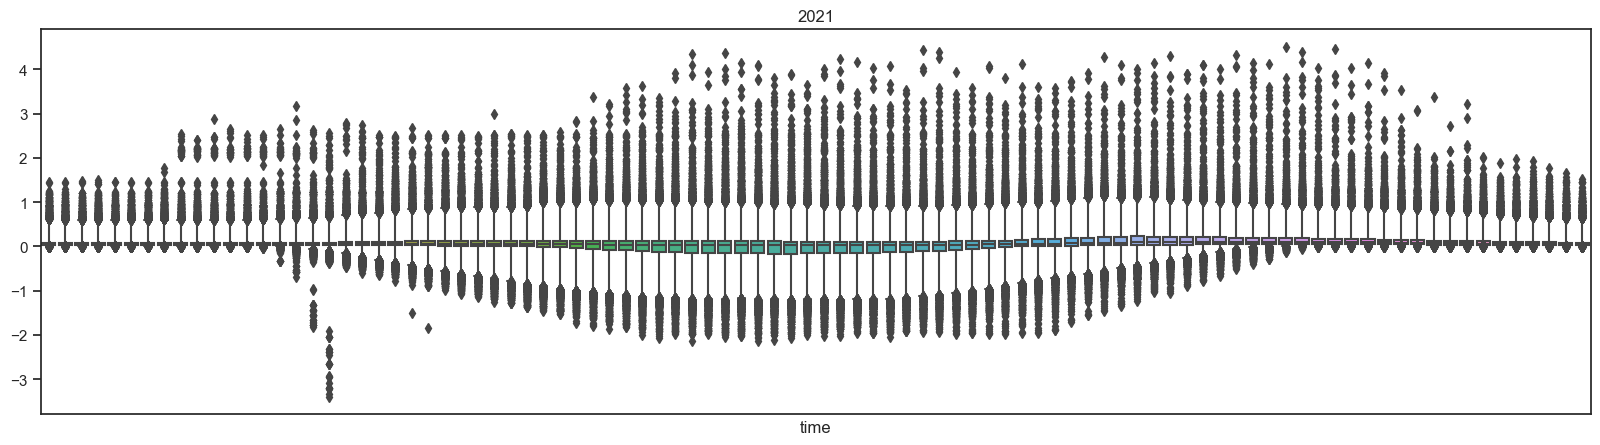

In [12]:
import seaborn as sns
# Create a boxplot of all values in the dataframe
plt.figure(figsize=(20,5))
sns.set(style="ticks", palette="pastel")
sns.boxplot(data=measures_per_day2016.iloc[:,2:], orient="v",whis=[1,99])
plt.title('2016')
plt.xticks([])
plt.show()

plt.figure(figsize=(20,5))
sns.set(style="ticks", palette="pastel")
sns.boxplot(data=measures_per_day2021.iloc[:,2:], orient="v",whis=[1,99])
plt.title('2021')
plt.xticks([])
plt.show()

Both plots show something very different. In the set of 2016, heat accumulation stones seem to play a very importat factor where there is a high consumption in the night. This isn't visible in the dataset of 2021 at all.

Therefore it seems best not to combine both (OR -> determine with the available data if a house has a stone or not)

### 2.2 Remove days based on features
In this section we'll remove days that show strange behaviour based on high-level features extracted from the data (Very high peaks, very low consumption), this allows to still keep the peaks and therefore no clipping etc. is needed

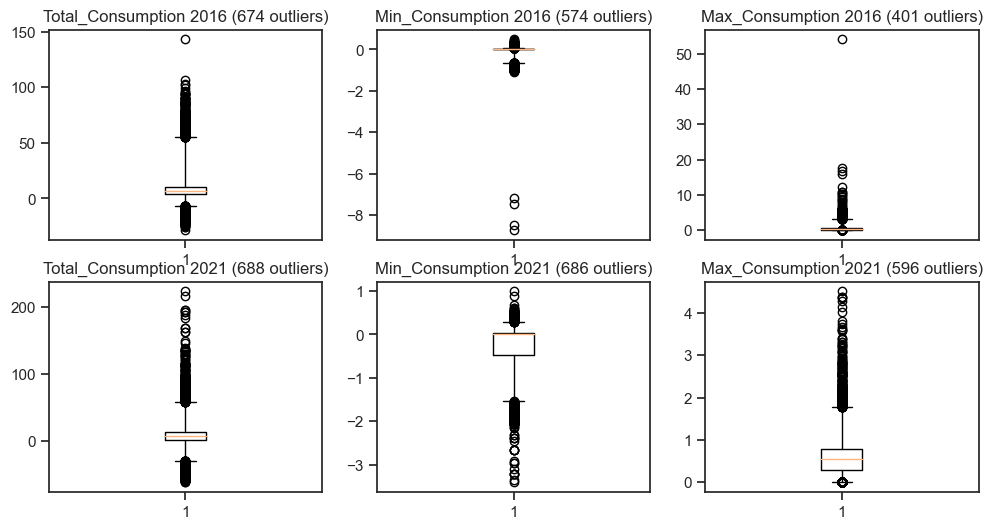

In [13]:
def remove_outliers(data, col, whiskers=[1, 99]):
    q1 = data[col].quantile(whiskers[0] / 100)
    q3 = data[col].quantile(whiskers[1] / 100)
    mask = (data[col] >= q1) & (data[col] <= q3)
    return data[mask]
temp2021 = measures_per_day2021.copy()
temp2021['Max_Consumption'] = temp2021.max(axis=1)
temp2021['Min_Consumption'] = temp2021.min(axis=1)
temp2021['Total_Consumption'] = temp2021.sum(axis=1)

temp2016 = measures_per_day2016.copy()
temp2016['Max_Consumption'] = temp2016.max(axis=1)
temp2016['Min_Consumption'] = temp2016.min(axis=1)
temp2016['Total_Consumption'] = temp2016.sum(axis=1)

# Plot box plots for Min, Max, and Total Consumption
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
consumption_types = ['Total_Consumption', 'Min_Consumption', 'Max_Consumption']
for n, (data,title) in enumerate(zip([temp2016, temp2021],['2016','2021'])):
    for i, consumption_type in enumerate(consumption_types):
        box = axs[n,i].boxplot(data[consumption_type], whis=[1, 99])
        upper_whisker = box['whiskers'][1].get_ydata()[1]
        lower_whisker =  box['whiskers'][0].get_ydata()[1]
        num_outliers = sum(data[consumption_type] > upper_whisker ) + sum(data[consumption_type] < lower_whisker)
        axs[n,i].set_title(f'{consumption_type} {title} ({num_outliers} outliers)')

Remove days which are outside the 1 - 99 quartile

In [14]:
measures_per_day2016_filtered = temp2016
measures_per_day2021_filtered = temp2021
for col in consumption_types:
    measures_per_day2016_filtered = remove_outliers(measures_per_day2016_filtered, col)
    measures_per_day2021_filtered = remove_outliers(measures_per_day2021_filtered, col)

measures_per_day2016_filtered  = measures_per_day2016_filtered.drop(columns=consumption_types)
measures_per_day2021_filtered  = measures_per_day2021_filtered.drop(columns=consumption_types)

Reanalyze the plots

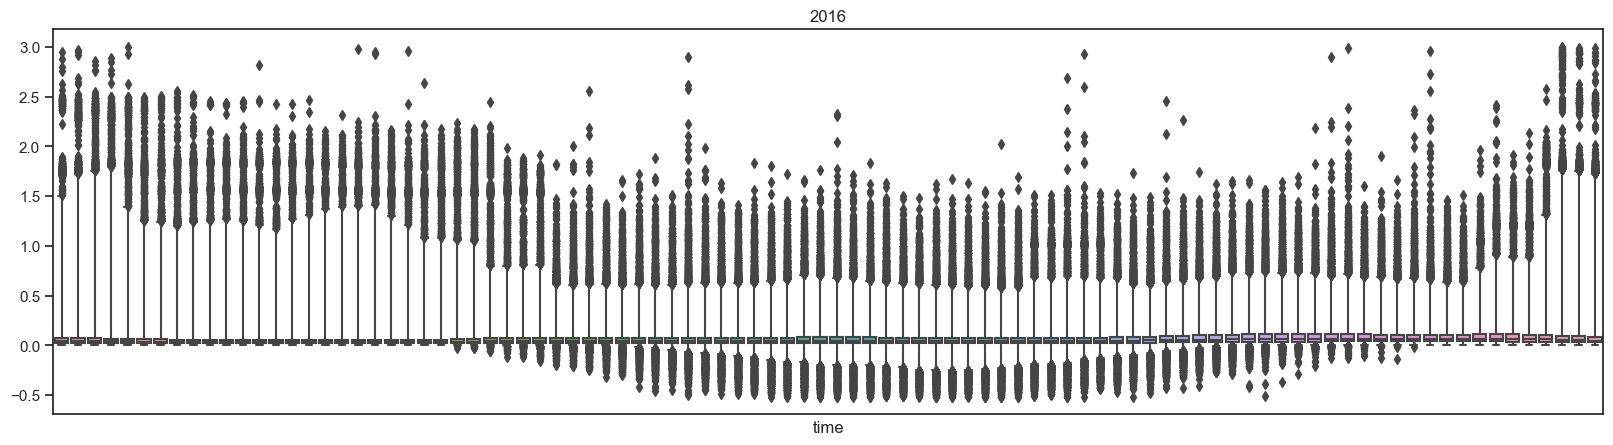

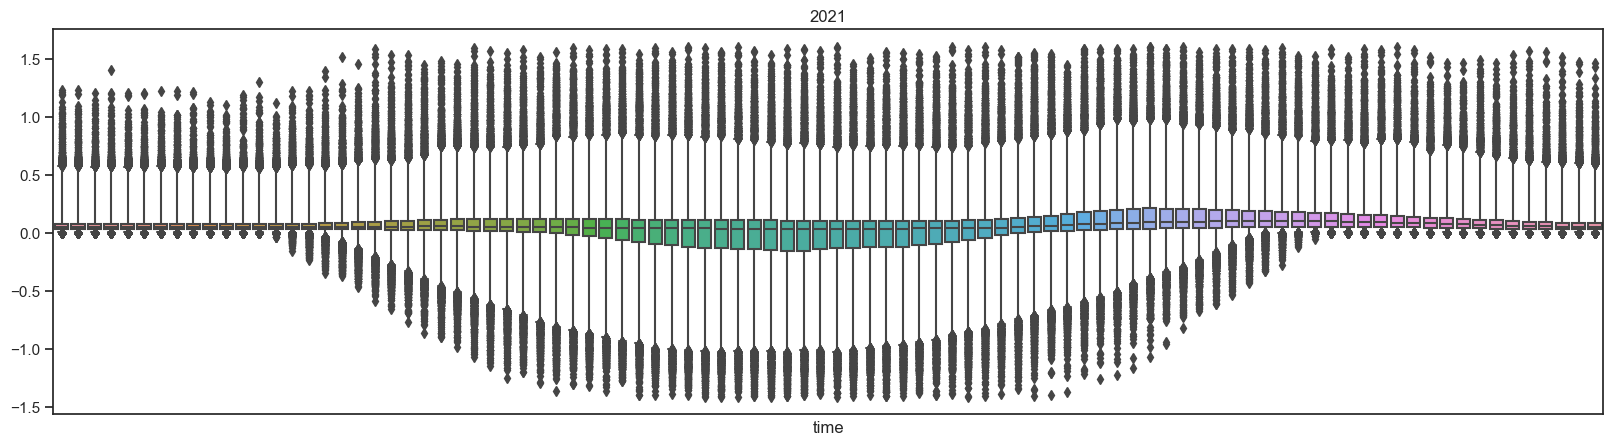

In [15]:

# Create a boxplot of all values in the dataframe
plt.figure(figsize=(20,5))
sns.set(style="ticks", palette="pastel")
sns.boxplot(data=measures_per_day2016_filtered.iloc[:,2:], orient="v",whis=[1,99])
plt.title('2016')
plt.xticks([])
plt.show()

plt.figure(figsize=(20,5))
sns.set(style="ticks", palette="pastel")
sns.boxplot(data=measures_per_day2021_filtered.iloc[:,2:], orient="v",whis=[1,99])
plt.title('2021')
plt.xticks([])
plt.show()

This looks a lot cleaner! Days with exceptional low/high consumption peaks or exceptional total consumption are filtered out

In [16]:
output_dir = os.path.join(WORKING_DIR,f'data2016_per_day_filtered.pkl')
measures_per_day2016_filtered.to_pickle(output_dir)
output_dir = os.path.join(WORKING_DIR,f'data2021_per_day_filtered.pkl')
measures_per_day2021_filtered.to_pickle(output_dir)

# 3. Add Attributes

In [17]:
def season_from_date(timestamp):
    year = timestamp.year
    seasons = [('winter', (pd.Timestamp(year, 1, 1), pd.Timestamp(year, 3, 20))),
               ('spring', (pd.Timestamp(year, 3, 21), pd.Timestamp(year, 6, 20))),
               ('summer', (pd.Timestamp(year, 6, 21), pd.Timestamp(year, 9, 22))),
               ('autumn', (pd.Timestamp(year, 9, 23), pd.Timestamp(year, 12, 20))),
               ('winter', (pd.Timestamp(year, 12, 21), pd.Timestamp(year, 12, 31)))]
    for season, (start, end) in seasons:
        if start <= timestamp <= end:
            return season

In [18]:
weather_dir =  r'C:\Thesis\data\weather_data2016-2021.pkl'
weather = pd.read_pickle(weather_dir).set_index('date_time')

In [19]:
# Group by ID and Date, and compute the mean for each day
def add_attributes(df,master_df,weather):
    df  = df.reset_index()
    df = df.copy()

    #Feature engineering
    df['Max_Consumption'] = np.round(df.iloc[:, 2:].max(axis=1),3)
    df['Min_Consumption'] = np.round(df.iloc[:, 2:].min(axis=1),3)
    df['Total_Consumption'] = np.round(df.iloc[:, 2:].sum(axis=1),3)

    #Weather information
    for column in ['maxtempC','mintempC','sunHour','cloudcover','precipMM']:
        df[column] = df['date'].apply(lambda x: weather.loc[str(x)][column])

    #Calender information
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.assign(  day_of_month = lambda x: x.index.day, 
                                     month = lambda x: x.index.month, 
                                     # year = lambda x: x.index.year, 
                                     day_of_week = lambda x: x.index.weekday,
                                     is_weekend = lambda x: x.index.day_of_week >=5,
                                     day_of_year = lambda x: x.index.day_of_year,
                                     season = lambda x: x.index.map(season_from_date))

    #Addition information
    df['yearly_offtake'] = np.round(df['ID'].apply(lambda x: master_df.loc[x]['Yearly Offtake']),3)
    df['yearly_injection'] =  np.round(df['ID'].apply(lambda x: master_df.loc[x]['Yearly Injection']),3)
    df['PV'] = np.where(df['yearly_injection'] == 0, 0, 1)

    return df

data2016_attr = add_attributes(measures_per_day2016_filtered, data_master2016, weather)
data2021_attr = add_attributes(measures_per_day2021_filtered, data_master2021, weather)

In [26]:
data2016_attr

time,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,day_of_month,month,day_of_week,is_weekend,day_of_year,season,yearly_offtake,yearly_injection,PV,ID
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.17,0.31,0.14,0.04,0.07,0.10,0.06,0.04,0.05,0.03,...,1,1,4,False,1,winter,1772.76,0.0,0,#NAAM?
2016-01-02,0.05,0.03,0.03,0.01,0.02,0.01,0.02,0.02,0.01,0.02,...,2,1,5,True,2,winter,1772.76,0.0,0,#NAAM?
2016-01-03,0.17,0.05,0.04,0.01,0.02,0.01,0.02,0.02,0.01,0.02,...,3,1,6,True,3,winter,1772.76,0.0,0,#NAAM?
2016-01-04,0.04,0.01,0.03,0.04,0.04,0.06,0.04,0.04,0.04,0.04,...,4,1,0,False,4,winter,1772.76,0.0,0,#NAAM?
2016-01-05,0.03,0.02,0.02,0.02,0.02,0.07,0.04,0.05,0.04,0.04,...,5,1,1,False,5,winter,1772.76,0.0,0,#NAAM?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.11,0.04,0.02,0.01,0.02,0.10,0.03,0.02,0.01,0.02,...,27,12,1,False,362,winter,1998.00,0.0,0,yDLi+QtPGI1ff9KKxnLYyqiXZBzpOQ
2016-12-28,0.05,0.01,0.03,0.03,0.08,0.02,0.01,0.02,0.01,0.03,...,28,12,2,False,363,winter,1998.00,0.0,0,yDLi+QtPGI1ff9KKxnLYyqiXZBzpOQ
2016-12-29,0.04,0.04,0.10,0.05,0.04,0.00,0.03,0.01,0.01,0.09,...,29,12,3,False,364,winter,1998.00,0.0,0,yDLi+QtPGI1ff9KKxnLYyqiXZBzpOQ


In [20]:
col = data2016_attr.pop('ID')
data2016_attr.insert(len(data2016_attr.columns), 'ID', col)

col = data2021_attr.pop('ID')
data2021_attr.insert(len(data2021_attr.columns), 'ID', col)

In [21]:
attr_columns = data2016_attr.columns[-17:]
data_columns = data2016_attr.columns[:96]

## 3.1 Quantile plots

In [22]:
#plot houses with and without pv
data2016_pv, data2016_nopv = data2016_attr[data2016_attr['PV'] == 1][data_columns], data2016_attr[data2016_attr['PV'] == 0][data_columns]
data2021_pv, data2021_nopv = data2021_attr[data2021_attr['PV'] == 1][data_columns], data2021_attr[data2021_attr['PV'] == 0][data_columns]

In [23]:
import altair as alt
alt.data_transformers.disable_max_rows()

def data_df_to_quantiles(data_df): 
    # q = np.concatenate([np.arange(0, 0.05, 0.01), np.arange(0.05, 0.96, 0.05), np.arange(0.95, 1.005, 0.01)])
    q = np.arange(0.05, 1.0, 0.05)
    quantiles = (
        data_df.quantile(q, interpolation = 'nearest')
        .set_axis((q*100).astype('int'), axis = 0)
    )
    lower_quantiles = quantiles.loc[:50, :].stack().to_frame('min').rename_axis(index = ['lower_quantile', 'timestamp'])
    upper_quantiles = quantiles.loc[50:, :].stack().to_frame('max').reset_index(level = 0).rename(columns = {'level_0':'upper_quantile'}).assign(lower_quantile = lambda x: 100-x.upper_quantile).set_index('lower_quantile', append = True).swaplevel(0,1).sort_index().rename_axis(index = ['lower_quantile', 'timestamp'])
    return lower_quantiles.join(upper_quantiles).reset_index().assign(quantiles = lambda x: x.lower_quantile.astype('str').str.zfill(2)+'-'+x.upper_quantile.astype('str').str.zfill(2)).drop(columns = ['lower_quantile', 'upper_quantile'])

def plot_quantiles(data_df,title):
    data_df['ID']  = 1
    data_df = data_df.reset_index().drop(columns=['date'])
    plot_df = data_df.groupby('ID').apply(data_df_to_quantiles).droplevel(1).reset_index()
    plot_df = plot_df[plot_df['timestamp'] != 'ID']

    area_chart = alt.Chart(plot_df,title=title).mark_area().encode(
        x = alt.X('timestamp',scale=alt.Scale(domain=[0,91])), 
        y= alt.Y('min:Q',title = 'consumption (kWh)',axis = alt.Axis(format = '.2f')),  
        y2='max:Q', 
        color= 'quantiles:O'
    )

    return area_chart.interactive()

In [25]:
chart = plot_quantiles(data2016_pv,'data 2016 with PV')
chart

TypeError: Object of type time is not JSON serializable

alt.Chart(...)

In [105]:
chart = plot_quantiles(data2016_nopv,'data 2016 with no PV')
chart

alt.Chart(...)

In [106]:
chart = plot_quantiles(data2021_pv,'data 2021 with PV')
chart

NameError: name 'data2021_pv' is not defined

In [107]:
chart = plot_quantiles(data2021_nopv,'data 2021 with no PV')
chart

NameError: name 'data2021_nopv' is not defined

### 4. TRAIN-VAL-TEST SPLIT
Create train, validation and test set by just random_sampling. Data is large enough to get a good distribution (later shown)

In [138]:
def split_train_val_test(data, frac=0.7, random_state=42):
    train = data.sample(frac=frac,random_state=random_state)
    rest = data.drop(train.index)
    # val = rest.sample(frac=1/2, random_state=random_state)
    # test = rest.drop(val.index)

    return train, rest

train2016, test2016 = split_train_val_test(data2016_attr.reset_index().drop(columns=['date']))
train2021, test2021 = split_train_val_test(data2021_attr.reset_index().drop(columns=['date']))

In [141]:
train2016.to_pickle(os.path.join(WORKING_DIR, 'train2016_preprocessed.pkl'))
test2016.to_pickle(os.path.join(WORKING_DIR, 'test2016_preprocessed.pkl'))
train2021.to_pickle(os.path.join(WORKING_DIR, 'train2021_preprocessed.pkl'))
test2021.to_pickle(os.path.join(WORKING_DIR, 'test2021_preprocessed.pkl'))


## 5.1 Plot some data

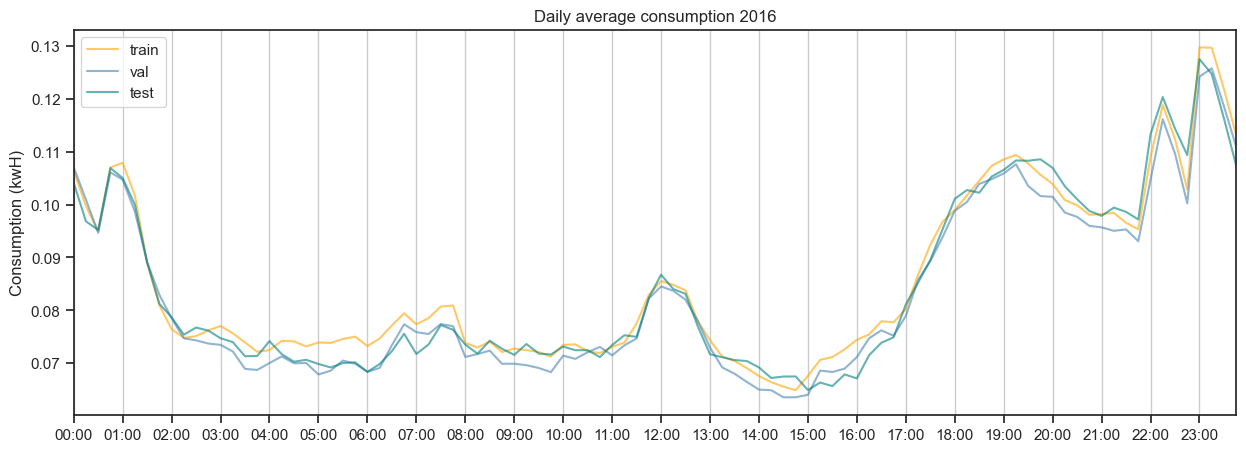

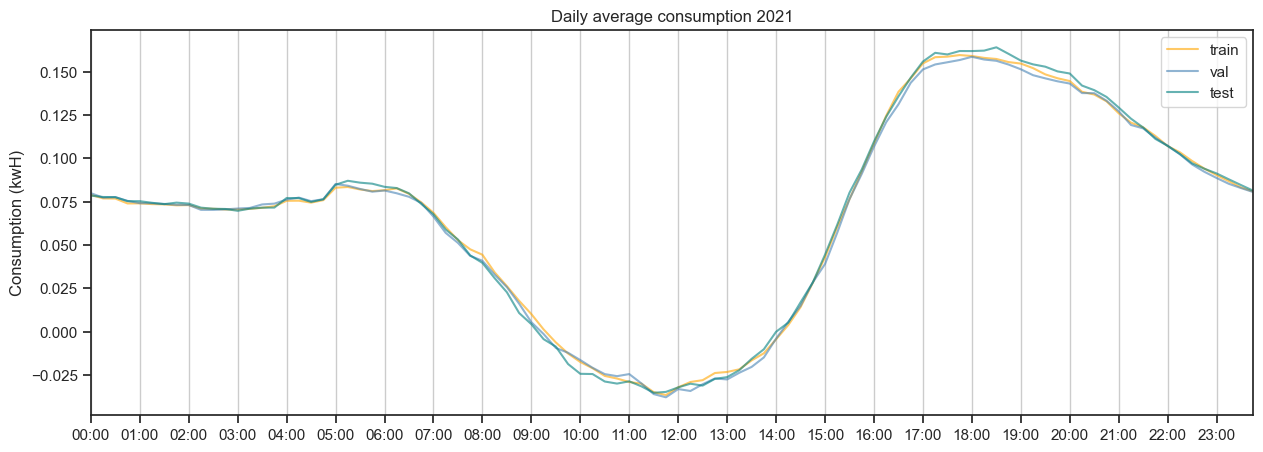

In [298]:
import sys
sys.path.append('..')
import utils
import plot

def plot_averages(train, val, test,data_columns, title):
    avg_train = utils.calculate_average(np.array(train[data_columns]))
    avg_test = utils.calculate_average(np.array(val[data_columns]))
    avg_val = utils.calculate_average(np.array(test[data_columns]))
    plot.plotday([avg_train,avg_val,avg_test],['train','val','test'],title)

plot_averages(train2016, val2016, test2016,data_columns,title='Daily average consumption 2016')
plot_averages(train2021, val2021, test2021,data_columns,title='Daily average consumption 2021')

2021


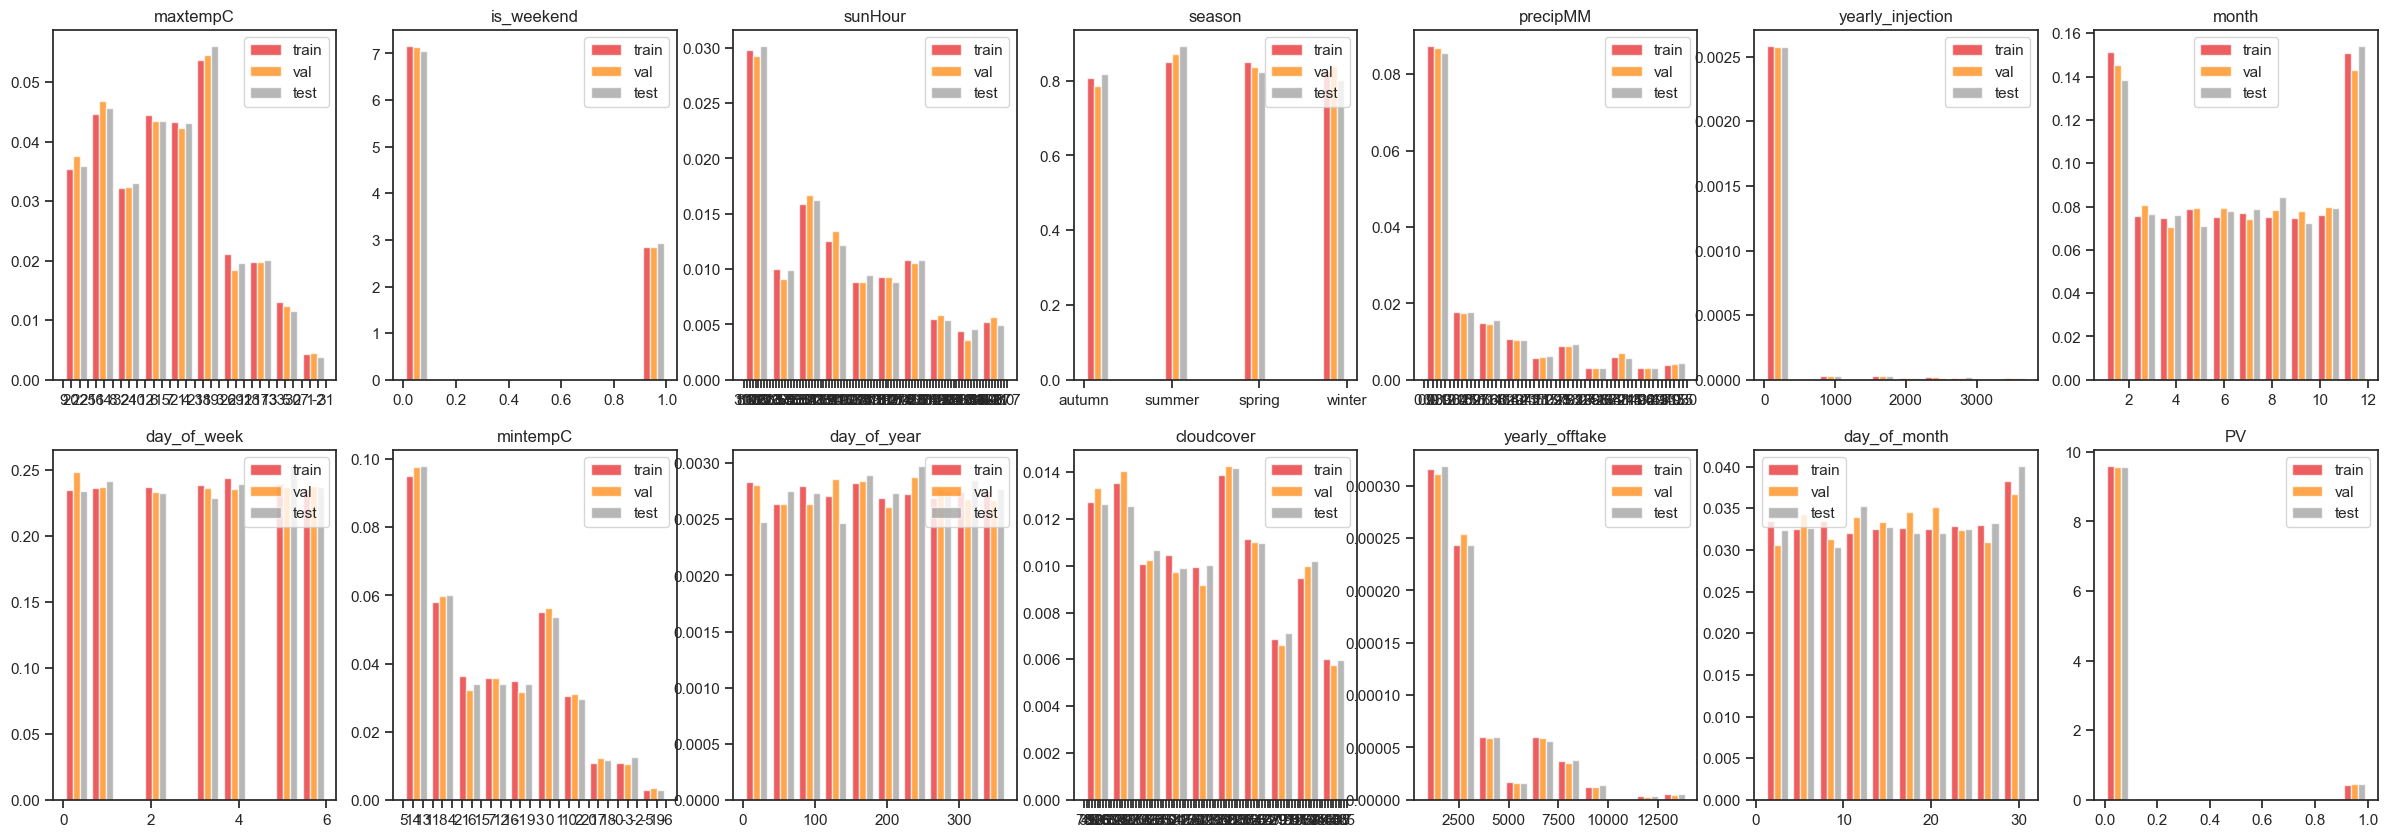

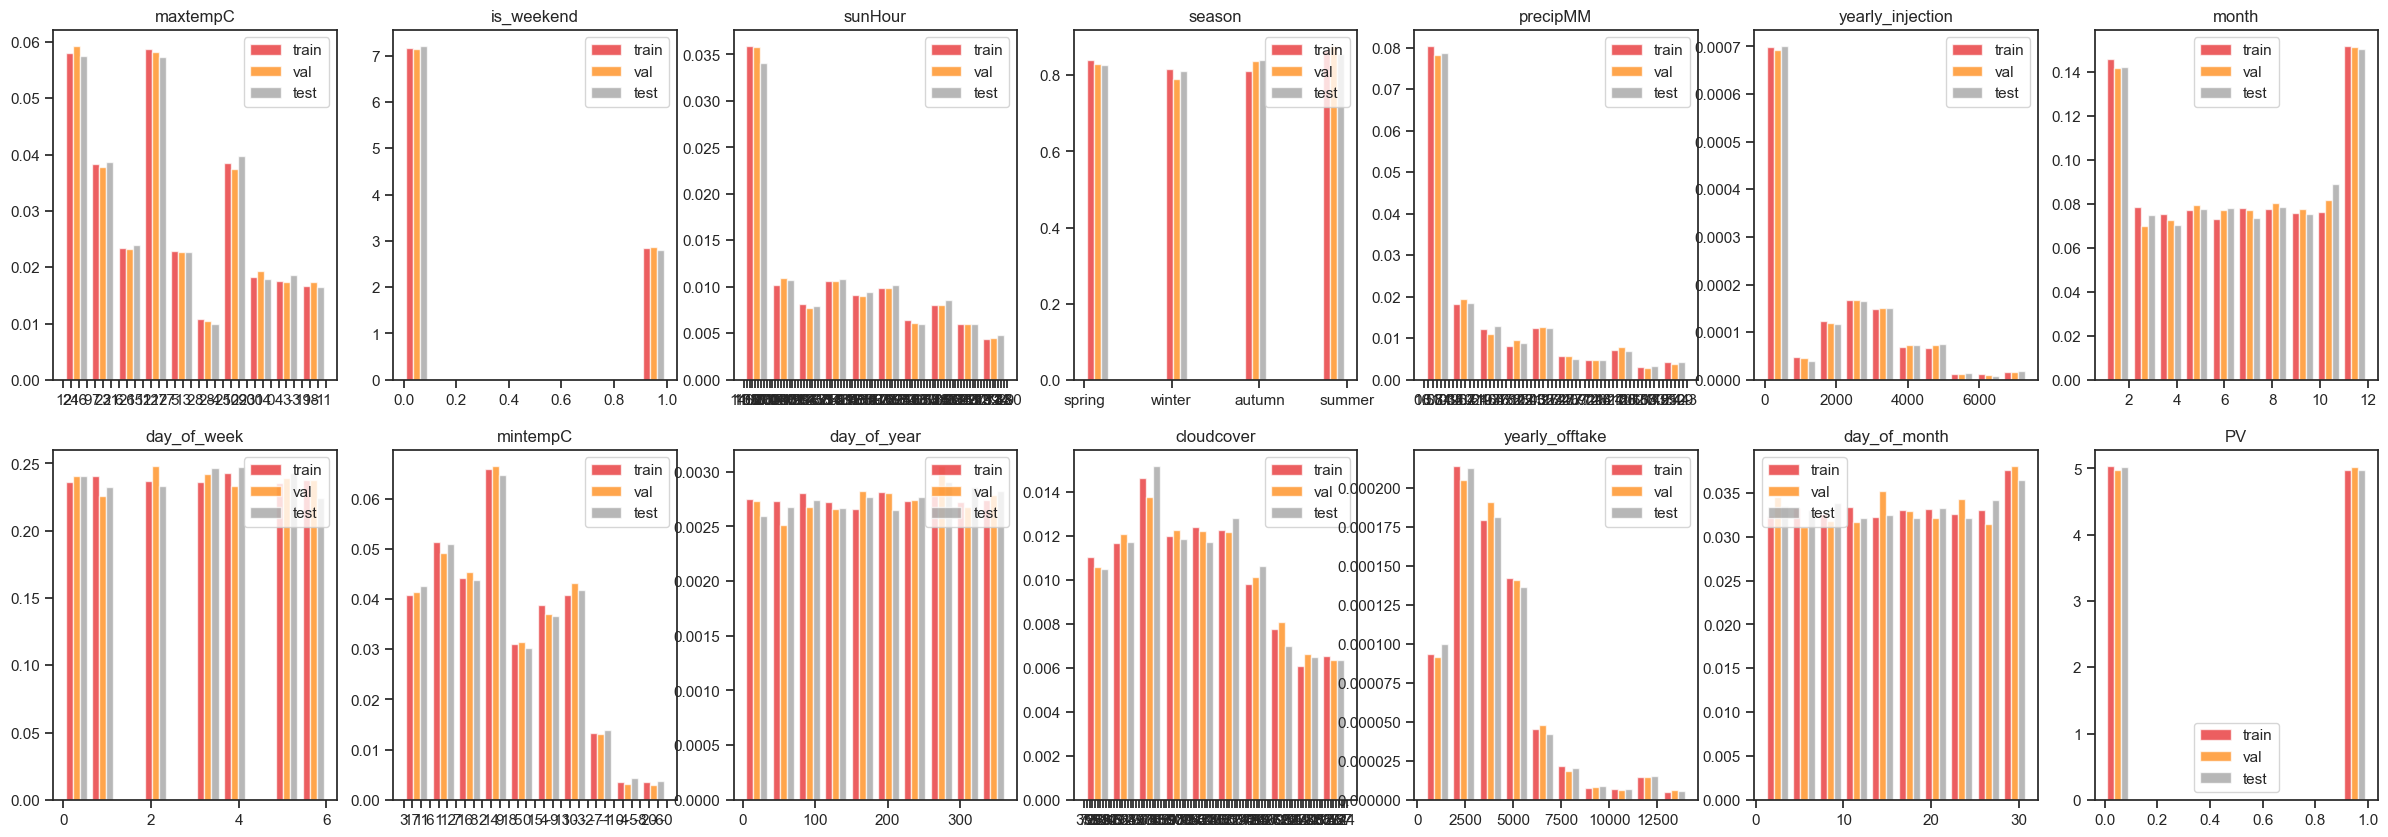

In [305]:
fig,axs = plt.subplots(2,7,figsize=(30,10))
for index, col in enumerate(attr_columns.tolist()[:-1]):
    row, column = index%2, index%7
    
    axs[row,column].hist([train2016[col],val2016[col],test2016[col]],density=True, color=plt.cm.Set1(np.linspace(0, 1, 3)),alpha=0.7)
    axs[row,column].legend(['train','val','test'])
    axs[row,column].set_title(col)

print('2021')
fig,axs = plt.subplots(2,7,figsize=(30,10))
for index, col in enumerate(attr_columns.tolist()[:-1]):
    row, column = index%2, index%7
    
    axs[row,column].hist([train2021[col],val2021[col],test2021[col]],density=True, color=plt.cm.Set1(np.linspace(0, 1, 3)),alpha=0.7)
    axs[row,column].legend(['train','val','test'])
    axs[row,column].set_title(col)

This way provides a good way to distribute the data in the different sets needed. Therefore we choose to perform the split when loading the data in the training notebooks.

### Export the df

In [307]:
for data, name in zip([train2016,val2016,test2016,train2021,val2021,test2021],['train2016','val2016','test2016','train2021','val2021','test2021']):
    output_dir = os.path.join(WORKING_DIR,'train',f'{name}.pkl')
    data.to_pickle(output_dir)